## Semantics Analysis of Movie Reviews Using Support Vector Machine

<b>Load the Data </b>

In [1]:
import os
import zipfile
from pathlib import Path

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [6]:
def load_data(data_dir):
    dataset = {}
    for file in os.listdir(data_dir):    
        if Path(file).suffix == '.zip':
            fpath = os.path.join(data_dir, file)
            with zipfile.ZipFile(fpath, 'r') as z:
                z.extractall(data_dir)
    for file in os.listdir(data_dir):
        if Path(file).suffix == '.txt':
            fpath = os.path.join(data_dir, file)
            fname = file.split('.')[0]
            with open(fpath) as f:                
                dataset[fname] = f.read().split('\n')
    dataset_DF = pd.DataFrame(dataset)
    return  dataset_DF

In [7]:
dataset_DF = load_data('data')

In [8]:
dataset_DF.head()

,reviews,labels
0,bromwell high is a cartoon comedy . it ran at ...,positive
1,story of a man who has unnatural feelings for ...,negative
2,homelessness or houselessness as george carli...,positive
3,airport starts as a brand new luxury pla...,negative
4,brilliant over acting by lesley ann warren . ...,positive


<b>There is a label for every review </b>

In [9]:
dataset_DF.count()

reviews    5000
labels     5000
dtype: int64

<b>Looking at the class distribution, we see a 50% distribution between the classes </b>

In [10]:
dataset_DF['labels'].value_counts()

negative    2500
positive    2500
Name: labels, dtype: int64

### Clean Data

In [11]:
#We will now remove common words that do not add value to the process using stop words
def generate_stop_words(listOfNewWords):
    stop_words = set(stopwords.words('english'))
    alphabet = 'abcdefghijklmnkopqrstuvwxyz'
    stop_words = stop_words.union(list('abcdefghijklmnkopqrstuvwxyz'), listOfNewWords)
    return stop_words
    

In [12]:
def prepare_data(feat_col, target_col, stop_words):
    # 1. remove punctuations
    feat_col = feat_col.apply(lambda words : [word for word in words.split() if word.isalpha()])
    # 2:  remove stop words
    feat_col = feat_col \
        .apply(lambda words : [word for word in words if word not in stop_words])
    # 3. Lemmatize transform the words into its root e.g. running, run, ran to root word: run.
    wnl = WordNetLemmatizer()
    feat_col = feat_col \
        .apply(lambda words : [wnl.lemmatize(word) for word in words])    
    dataframe = pd.DataFrame({'reviews':feat_col.apply(lambda x : ' '.join(x)), 'labels': target_col})    
    return dataframe

### Encode Data

In [13]:
def encode_data(feat_col, target_col):
    # 1. encode 'negative' = 0 and 'positive = 1'
    le = preprocessing.LabelEncoder()
    target_col = le.fit_transform(target_col)
    # 2. Build a dictionary of features and features to feature vectors:
    count_vect = CountVectorizer()
    feat_col = count_vect.fit_transform(feat_col)
    # 3: use tf and tf–idf to normalize frequency of words and downplay the presence of frequenty occuring words
    tfidf_transformer = TfidfTransformer()
    feat_col = tfidf_transformer.fit_transform(feat_col)
    #dataframe  = pd.DataFrame({'reviews':feat_col, 'labels':target_col})
    return feat_col, target_col,count_vect, tfidf_transformer

### Design SVM Model

In [27]:
def design_svm_model(feat_col, target_col):
    model = SVC(kernel='linear', probability=True)
    model.fit(X= feat_col, y = target_col)
    score = model.score(feat_col, target_col)
    y_predict = model.predict(feat_col)
    accuracy = accuracy_score(y_true= target_col, y_pred= y_predict) 
    conf_matrix = confusion_matrix(y_true= target_col,y_pred= y_predict)
    return model, score, accuracy, conf_matrix

### Make Predictions

In [15]:
def make_predictions(review, model, count_vect, transformer):
    review = count_vect.transform(review)
    review = transformer.fit_transform(review)
    prediction = model.predict(review)
    target_mapping = {0:'negative', 1 : 'positive'}
    prediction = target_mapping[prediction[0]]
    print('SVM Predicted: ', prediction)

### Execute

In [22]:
stop_words = generate_stop_words(['bromwell'])

In [23]:
step_prep = prepare_data(dataset_DF['reviews'],dataset_DF['labels'], stop_words)

In [24]:
feat_col, target_col, count_vect, transformer = encode_data(step_prep['reviews'],step_prep['labels'])

In [25]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(feat_col, target_col, test_size=0.25, random_state=None)

In [28]:
# step_model = design_svm_model(feat_col, target_col)
step_model, score, accuracy, conf_matrix = design_svm_model(X_train, y_train)

In [58]:
sample_review = ['want my money back']
make_predictions(sample_review, step_model, count_vect, transformer)

SVM Predicted:  negative


### Model Evaluation

In [59]:
print('Train Score: ', score)

Train Score:  0.9925333333333334


In [31]:
### Accuracy
print('Accuracy Score: ', accuracy)

Accuracy Score:  0.9925333333333334


In [60]:
confusion_MX = pd.DataFrame(conf_matrix, columns=['positive', 'negative'], index= ['positive', 'negative'])

In [61]:
confusion_MX

,positive,negative
positive,1869,17
negative,11,1853


f1= 0.8953579858379229
Area Under Curve = 0.9636612015367054
Average Precision =0.9637055875919396



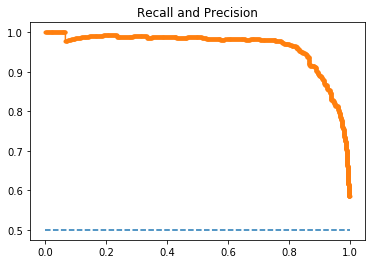

In [62]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

probs = step_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
yhat = step_model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs)
#The F1 score can be interpreted as a weighted average of the precision and recall, 
#where an F1 score reaches its best value at 1 and worst score at 0
f1 = f1_score(y_test, yhat)
auc = auc(recall, precision)
average_precision = average_precision_score(y_test, probs)
print('f1= {}\nArea Under Curve = {}\nAverage Precision ={}\n'.format(f1, auc, average_precision))
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.title('Recall and Precision')
plt.show()

Area Under Curve: 0.9632602995103763


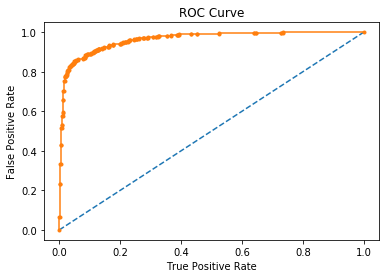

In [63]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, probs)
print('Area Under Curve:', auc)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.show()